# CS 440 Final Project: Clickbait Detection

### Team members: Joshua Burris, Caleb Tong

In [267]:
# Testing
testing_mode = False
argv = ['train/train_clickbait.txt', 'test/test_clickbait.txt', 'train/train_nonclickbait.txt', 'test/test_nonclickbait.txt']

## Language Model:

In [268]:
import math, string
from collections import Counter

class language_model:
    '''
    Initialize a language model

    Parameters:
    ngram specifies the type of model:  
    unigram (ngram = 1), bigram (ngram = 2), trigram (ngram = 3), etc.
    '''
    def __init__(self, ngram=1) :
        self.ngram = ngram
    
    '''
    Trains our language model on all sentences in a given file (provided the file name).
    V: The number of total unigrams.
    total_count: The total sum of the unigram frequencies.
    '''
    def train(self, text) :
        
        # Get sentences
        sentences = self.get_sentences(text)
        
        # Get unigram frequency data
        self.unigrams = Counter()
        for s in sentences :
            for w in s.split() :
                self.unigrams[w] += 1
        
        if testing_mode :
            print('Unigrams:')
            for word, freq in self.unigrams.most_common(10) :
                print("{}\t{}".format(word, freq))
            print()
            
        # Get the number of total unigrams, and the total sum of their frequencies
        self.V = len(self.unigrams)
        self.total_count = sum(self.unigrams.values())
        
        # If we are using an ngram of 2 or more we need a frequency list of bigrams
        if self.ngram > 1:
            self.bigrams = Counter()
            
            for s in sentences :
                words = s.split()
                for i in range(len(words) - 1):
                    self.bigrams[words[i] +' '+ words[i+1]] += 1
                        
            # Update V and total_count if we are using more than one gram
            self.V = len(self.bigrams)
            self.total_count = sum(self.bigrams.values())
            
            if testing_mode :
                print('Bigrams:')
                for word, freq in self.bigrams.most_common(10) :
                    print("{}\t\t{}".format(word, freq))
                print()
        
        # If we are using an ngram of 3 or more we need a frequency list of trigrams
        if self.ngram > 2:
            self.trigrams = Counter()
            
            for s in sentences :
                words = s.split()
                for i in range(len(words) - 2):
                    self.trigrams[words[i] +' '+ words[i+1] +' '+ words[i+2]] += 1
            
            # Update V and total_count if we are using more than one gram
            self.V = len(self.trigrams)
            self.total_count = sum(self.trigrams.values())
            
            if testing_mode :
                print('Trigrams:')
                for word, freq in self.trigrams.most_common(10) :
                    print("{}\t\t\t{}".format(word, freq))
                print()
        
        if testing_mode :
            print('Number of ngrams:', self.V)
            print('Total of ngram frequencies:', self.total_count)
            print()
    
    '''
    Tests our language model on all sentences in a given file (provided the file name).
    Returns: The perplexity value calculated from the provided sentences in the provided file.
    sparsity: The ratio of n-grams not in the frequency data over those that were in the frequency data.
    '''
    def test(self, text) :
        
        # Get sentences
        sentences = self.get_sentences(text)
        
        # Calculate sparsity
        non_entries = 0
        entries = 0
        for s in sentences :
            words = s.split()
            for i in range(len(words) - (self.ngram - 1)) :
                gram = ' '.join(words[i:i+self.ngram])
                if self.count([gram]) :
                    non_entries += 1
                entries += 1
        
        self.sparsity = non_entries / entries
        
        return self.perplexity(sentences)
    
    '''
    Returns the perplexity of a list of sentences given by the equation: PP(W) = 2^E(W)
    '''
    def perplexity(self, sentences):
        return math.pow(2, self.entropy(sentences))
    
    '''
    Returns the entropy of a list of sentences given by the equation: E(W) = Sum(P(w_i, w_(i-k)...w_(i-1)))
    '''
    def entropy(self, sentences):
        e = 0
        offset = self.ngram - 1
        length = 0
        
        for s in sentences :
            words = s.split()
            length += len(words)
            for i in range(offset, len(words)) :
                # context is the previous word/words for the bigram/trigram.
                context = words[i - offset : i]
                e += -math.log(self.probability(words[i], context), 2)  
        return e / length
    
    '''
    Returns the probability of a word given by the equation: P(w_i | w_(i-1)) = C(w_(i-1), w_i) / C(w_(i-1))
    '''
    def probability(self, word, context):
        return (self.count(context + [word]) + 1) / (self.count(context) + self.V)
    
    '''
    Returns the frequency of a list of words you give it as context. It can be used for any ngram context.
    '''
    def count(self, context):
        size = len(context)
        words = ' '.join(context)
        
        if size == 1: return self.unigrams.setdefault(words, 0)
        if size == 2: return self.bigrams.setdefault(words, 0)
        if size == 3: return self.trigrams.setdefault(words, 0)
        
        return 0
    
    def get_sentences(self, text):
        
        sentences = []
        
        lines = text.split('\n')
        
        for l in lines :
            # Convert to lower case.
            l = l.lower()
            
            # Convert question marks (?), colons (:) and exclamation marks (!) to periods.
            # Dashes should be converted to spaces.
            # Remove all punctuation marks other than the period (commas, semicolons, underscores and quotes).
            l = l.translate(str.maketrans('?:!-', '... ', string.punctuation.replace('.', '')))
            
            # Replace whitespace with a single space.
            l = ' '.join(l.split())
            
            new_line = ''
            for i in range(len(l)) :
                if l[i] == '.' and i != len(l) - 1 and l[i+1] != ' ' :
                    continue
                else :
                    new_line += l[i]
            l = new_line
            
            # Parse the line into sentences, adding beginning-of-sentence and end-of-sentence tokens.
            for s in l.split('.') :
                s = s.strip()
                if s :
                    sentences.append('<s> '+ s +' </s>')
        
        return sentences

## Which N-gram is the most useful:

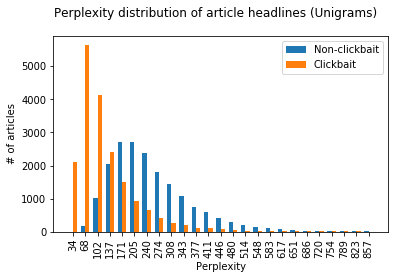

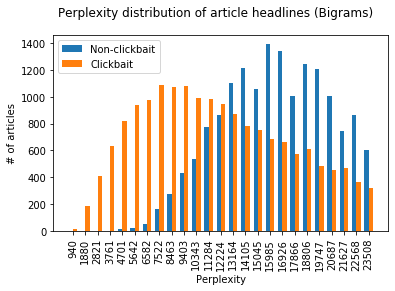

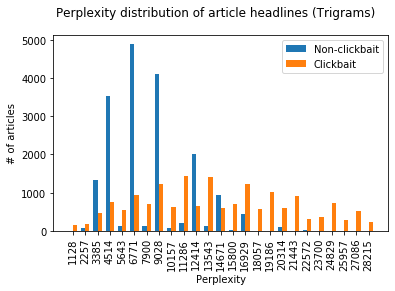

In [269]:
import matplotlib.pyplot as plt
import numpy as np

def get_bins(num_bins, maximum, data) :
    bins = [0]*num_bins
    for p in data :
        if p < maximum :
            bins[int((p / maximum) * num_bins)] += 1
    return bins

# Graph shaping values:
num_bins = 25
width = 0.35

for ngram in range(1, 4) :
    nc_perps = []
    c_perps = []
    maximum = 0
    
    c_model = language_model(ngram)
    c_model.train(open(argv[0], 'r').read())
    for line in open(argv[1], 'r').readlines() :
        line = line.strip()
        if line :
            perp = c_model.test(line)
            c_perps.append(perp)
            if perp > maximum :
                maximum = perp

    nc_model = language_model(ngram)
    nc_model.train(open(argv[2], 'r').read())
    for line in open(argv[3], 'r').readlines() :
        line = line.strip()
        if line :
            perp = nc_model.test(line)
            nc_perps.append(perp)
            if perp > maximum :
                maximum = perp
        
    nc_bins = get_bins(num_bins, maximum, nc_perps)
    c_bins = get_bins(num_bins, maximum, c_perps)

    ind = np.arange(num_bins)

    plt.bar(ind, nc_bins, width, label='Non-clickbait')
    plt.bar(ind+width, c_bins, width, label='Clickbait')

    plt.xlabel('Perplexity')
    plt.ylabel('# of articles')
    title = 'Perplexity distribution of article headlines'
    if ngram == 1 : plt.suptitle(title + ' (Unigrams)')
    elif ngram == 2 : plt.suptitle(title + ' (Bigrams)')
    elif ngram == 3 : plt.suptitle(title + ' (Trigrams)')
    plt.legend(loc='best')

    # You need to change xticks or else they will display 0 to num_bins
    plt.xticks(ind + width / 2, (int(((i+1) / num_bins) * maximum) for i in range(num_bins)), rotation='vertical')
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()

## Calculating if it's clickbait:

In [270]:
best_ngram = 1

clickbait_model = language_model(best_ngram)
clickbait_model.train(open(argv[0], 'r').read())

notclickbait_model = language_model(best_ngram)
notclickbait_model.train(open(argv[2], 'r').read())

def is_clickbait(article_headline) :
    clickbait_perp = clickbait_model.test(article_headline)
    notclickbait_perp = notclickbait_model.test(article_headline)
    
    if clickbait_perp < notclickbait_perp :
        return True, 100*( 1-(clickbait_perp/(clickbait_perp+notclickbait_perp)) )
    else :
        return False, 100*( 1-(notclickbait_perp/(clickbait_perp+notclickbait_perp)) )

## How accurate is our model:

In [271]:
for ngram in range(1, 4) :
    print('ngram:', ngram)
    
    c_model = language_model(ngram)
    c_model.train(open(argv[0], 'r').read())
    
    nc_model = language_model(ngram)
    nc_model.train(open(argv[2], 'r').read())
    
    correct = 0.0
    total = 0.0
    for line in open(argv[1], 'r').readlines() :
        line = line.strip()
        if line :
            c_perp = c_model.test(line)
            nc_perp = nc_model.test(line)
            if c_perp < nc_perp :
                correct += 1.0
            total += 1.0
    
    c_accuracy = correct / total
    print('Clickbait accuracy: {:.2f}%'.format(100.0*c_accuracy))
    
    correct = 0.0
    total = 0.0
    for line in open(argv[3], 'r').readlines() :
        line = line.strip()
        if line :
            c_perp = c_model.test(line)
            nc_perp = nc_model.test(line)
            if nc_perp < c_perp :
                correct += 1.0
            total += 1.0
    
    nc_accuracy = correct / total
    print('Nonclickbait accuracy: {:.2f}%'.format(100.0*nc_accuracy))
    print()

ngram: 1
Clickbait accuracy: 95.49%
Nonclickbait accuracy: 77.48%

ngram: 2
Clickbait accuracy: 94.45%
Nonclickbait accuracy: 55.30%

ngram: 3
Clickbait accuracy: 93.55%
Nonclickbait accuracy: 9.31%



## Try it yourself:

In [ ]:
print("Press \"stop\", \"quit\", or \"exit\" to stop", end='\n\n')

while True :
    article_headline = input('Give me an article headline: ').lower()
    
    if article_headline == 'stop' or article_headline == 'exit' or article_headline == 'quit' :
        break
    
    is_cb, percentage = is_clickbait(article_headline)
    
    if is_cb :
        print("We are {:.2f}% sure it's clickbait".format(percentage))
    else :
        print("We are {:.2f}% sure it's not clickbait".format(percentage))
    
    print()

Press "stop", "quit", or "exit" to stop

